In [1]:
using GeoPhyInv
using Statistics
using Random
using DSP
using MLDataUtils
using HDF5
using Plots; gr();
using LaTeXStrings;
using Revise

In [2]:
GeoPhyInv.@init_parallel_stencil(2, true, Float32, 2) #ndims, use_gpu, datatype, orderm of finite-difference

In [3]:
#Medium Properties and Reference Values 

#6.5km in x direction, and 6km in z direction. 1301 points in x direction, and 1201 points in z direction
gridspace = 5
xgrid = range(0.0, stop=6500., step=gridspace)
zgrid = range(0.0, stop=6000., step=gridspace)

mgrid = [zgrid, xgrid]

medium = Medium(mgrid, [:vp, :rho])

# reference values 
vp = 3000 * ones(length.(mgrid)...)
rho = 2000 * ones(length.(mgrid)...)

copyto!(medium[:vp], vp)
copyto!(medium[:rho], rho)

update!(medium, 0.9) #1.0

medium

> 2-D Medium with [:z, :x] in [[0.0, 6000.0], [0.0, 6500.0]]
> number of samples:	[1201, 1301]
> sampling intervals:	[5.0, 5.0]
> vp:	min	3000.0	max	3000.0
> rho:	min	2000.0	max	2000.0
> Bounds:
5-element Named Vector{Vector{Float64}}
vcat  │ 
──────┼──────────────────────────
:vp   │           [300.0, 5700.0]
:rho  │           [200.0, 3800.0]
:K    │       [1.8e7, 1.23462e11]
:KI   │ [8.09966e-12, 5.55556e-8]
:rhoI │      [0.000263158, 0.005]


In [4]:
function new_medium(medium; gridspace=5., water_depth=2300., reflector_depth=4200., velocities = nothing, water_perturbation=0)
    medium_new=deepcopy(medium)
    vp = medium[:vp]
    rho = medium[:rho]
    water_vels =  Vector{Float32}(undef, Int(1100/gridspace+1)) #collect water velocities up to 1.2km depth
    
    water_depth_pt = argmin(abs.(zgrid .- water_depth)) #water depth can be anywhere between 1.2 to 2.4m
    reflector_depth_pt = argmin(abs.(zgrid .- reflector_depth))
    
    if velocities == nothing
        first_layer_vel = medium.bounds[:vp][end]/2
        scd_layer_vel = medium.bounds[:vp][end]
    else
        first_layer_vel = velocities[1]
        scd_layer_vel = velocities[2]
    end
        
   function pt_to_coord(pt)
        #= takes takes gridpoint, and returns its coordinate value in m =#
        coord= pt*gridspace
        return coord
    end
    
    function Hood_function(zcoord)
        #= takes zcoord in m, applies the hoods function and returns the velocity at depth z in m/s =#
        velocity = 1541.30 - 0.18026 * zcoord + 2.12895*(10^-4) * zcoord^2 - 1.15430*(10^-7) * zcoord^3 + 3.28150*(10^-11) * zcoord^4 - 4.62212*(10^-15) * zcoord^5 +  2.52598*(10^-19) * zcoord^6 
        return velocity 
    end
     

    for i in 1:water_depth_pt 
        zcoord = pt_to_coord(i)
        water_velocity = Hood_function(zcoord)        
        if water_perturbation != 0
            if zcoord <= 1000
                perturb_C = (cos((zcoord/1000)*(pi/2))^2)*(water_perturbation/100*water_velocity)
                water_velocity = water_velocity + perturb_C  
            end
        end
        vp[i, :] .= water_velocity 
        rho[i,:] .= 1030 #kg/m^3
    end 
          
    #Plug in values for first subsurface layer
    #first_layer_vel = medium.bounds[:vp][end]/2
    vp[water_depth_pt+1: reflector_depth_pt-1, :] .= first_layer_vel 
    rho[water_depth_pt+1: reflector_depth_pt-1, :] .= (0.31*(first_layer_vel^0.25))*(10^3) #Gardner's density in g/(cm^3), converted to kg/(m^3) by multiplying by (10^3)
    #vp[1:argmin(abs.(zgrid .- water_depth)), :] .= water_velocity 
   
    #Plug in values for second subsurface layer
    #vp[reflector_depth_pt:end, :] .= medium.bounds[:vp][end]
    vp[reflector_depth_pt:end, :] .= scd_layer_vel    
    rho[reflector_depth_pt:end, :] .= (0.31*(scd_layer_vel^0.25))*(10^3)
    
    #Collect water velocities up to 1.2km in a vector
    water_vels =vp[1:Int(1100/gridspace+1), 650] #650 is the x domain mid-point #If we want in future iterations, we cnan return this as another parameter of medium new in the future. 
    
    #Update medium
    copyto!(medium_new[:vp], vp)
    copyto!(medium_new[:rho], rho)
    
    update!(medium_new, 0.1)
    return medium_new
end

new_medium (generic function with 1 method)

In [5]:
#Making sure perturbed water velocities makes sense
using Plots.PlotMeasures
#n_medium = similar(medium)
n_medium = new_medium(medium;water_perturbation = 0)
n_medium_2  = new_medium(medium;water_perturbation = -6.0)
n_medium_3 = new_medium(medium;water_perturbation = 6.0)

vp_z_water = n_medium[:vp][1:241, 650]                 #new medium vp has dimensinos 1201*1301
vp_z_water_2 = n_medium_2[:vp][1:241, 650]
vp_z_water_3 = n_medium_3[:vp][1:241, 650]
depth_z = collect(0.000:0.005:1.2)                                   #1.2km deep 
plot(vp_z_water_2, depth_z, label= " Minimum velocity", legend = :bottomright, size=(550,450),fmt = :png)
plot!(vp_z_water, depth_z, label= " Hood's velocity")
plot!(vp_z_water_3, depth_z, label= " Maximum velocity")
yticks!([0:0.1:1.2;])
yflip!(true)
xlabel!("Velocity (m/s)")
ylabel!("Depth (km) ")
title!("Acoustic Wave Speed in Water")
#savefig("MIT Images/SYMAE/Water_velocity_range_66")
savefig("Water_velocity_range_66")

In [6]:
#Set Acquisition Geometry (Source/Rec Location) Parameters
#Has to be called everytime water depth changes
nr=100
ns=1
function get_ageom(;water_depth=2300)
    ageom=AGeom(medium.mgrid, :surf, SSrcs(ns), Recs(nr)) # surface acquisition
    update!(ageom, Recs(nr), [water_depth,xgrid[1]], [water_depth,xgrid[end]], [1,nr])
    update!(ageom, SSrcs(ns), [10.0,xgrid[end]/2], [10.0,xgrid[end]/2], [1,ns])
end
ageom=get_ageom()
println(ageom)


> 2-D acquisition with 1 supersource(s), [1] source(s) and [100] receiver(s)



In [7]:
#Set Source and Time Sampling Parameters
#Depends on acquisition geometry
#We want to sample for at least 8 seconds to capture at least 4 arrivals. 

wav, tgrid=ricker(medium, 20, 1.5,) #returns a maximum frequency of 20.18, with 6.78Hz as the central frequency. 
#tgrid=range(0.0, stop=9.0, step=0.005) #stop = 9.0
#wav = ricker(7.0, tgrid, tpeak = 1.0)   #7 is the peak frequency, the max frequency at this is 20.887Hz. 
srcwav = SrcWav(tgrid, ageom, [:p])
GeoPhyInv.update!(srcwav, [:p], wav)
println(length(tgrid))


freqmax=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:max)
freqpeak=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:peak)
freqmin=GeoPhyInv.Utils.findfreq(wav,tgrid,attrib=:min)
tmax=maximum(tgrid); nt=length(tgrid); dt=step(tgrid) 

plot(srcwav[1].d)

println("maximum frequency modeled\t", freqmax)
println("Peak (most energetic) frequency modelled\t", freqpeak)
println("current sampling frequency \t",inv(dt))
println("we can subsample by a factor of \t",inv(dt)/4/freqmax)
println("time range: ",tmax, ", n timesteps: ", length(tgrid), "dt: ", dt)

subsample_factor = 19

14262
maximum frequency modeled	20.234498635384504
Peak (most energetic) frequency modelled	6.7825135090674324
current sampling frequency 	1612.2034611053286
we can subsample by a factor of 	19.918994413407823
time range: 8.845657725001187, n timesteps: 14262dt: 0.000620269106303989


19

┌ Info: frequency bounds for propagating wavefield 1 are: [1.13e-01, 1.87e+01], with peak at: 4.75e+00
└ @ GeoPhyInv /math/home/eruisun/.julia/packages/GeoPhyInv/1J1nX/src/fdtd/updates.jl:147
┌ Warning: decrease time sampling (6.20e-04) below 5.85e-04
└ @ GeoPhyInv /math/home/eruisun/.julia/packages/GeoPhyInv/1J1nX/src/fdtd/stability.jl:53


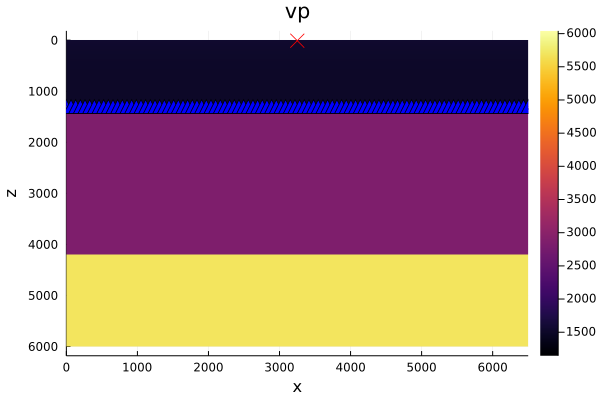

In [24]:
# Create Random Forward Model for Memory Allocations, using Proper Model we want. 
#n_medium = similar(medium)
n_medium= new_medium(medium;water_depth=1300)
ageom=get_ageom(;water_depth=1300)

tsnaps=tgrid[1:div(length(tgrid),100):end] # store 20 snapshots
rfields= [:p]  # add as many fields are possible here to record

pa = SeisForwExpt(
    FdtdAcoustic(),
    snaps_field=:p, # 
    tsnaps=tsnaps,
#    pml_edges=[:xmin, :xmax, :zmax, :ymin, :ymax], # if you want surface waves to be modelled
#    pml_edges=[:xmin, :xmax, :zmax, :zmin, :ymin, :ymax], # absorbing BC on edges
    medium = n_medium,
    ageom = ageom,
    rfields=rfields,
    srcwav = srcwav,
    sflags = [2],
    rflags = [1],
    tgrid = tgrid,
#     zfree = 0, # location of the stree-free boundary
    verbose = false,
);

heatmap(n_medium, :vp)
plot!(ageom, Recs())
plot!(ageom, SSrcs())

In [9]:
collect(tsnaps)[44]

3.7873631630921567

In [10]:
update!(pa)

In [11]:
#View acoustic simulation 

function plot_snapshots(name)
    clip_perc = 50
    pmax = maximum([maximum(pa[:snaps][it]) for it = 1:length(tsnaps)])
    pmax -= pmax * 0.01 * clip_perc

    anim = @animate for it = 1:length(tsnaps)
        f = pa[:snaps, 1][it];
        heatmap(
                f, aspect_ratio = 1,
                         yticks = (401, "2000m"),
                         xlims = (1, size(f, 2)),
                         ylims = (1, size(f, 1)),
                         yflip = true,
                         seriescolor = cgrad(:seismic),
                         clims = (-pmax, pmax),
                         legend = false,
             title = string("snapshot at: ", round(tsnaps[it], digits = 5), " s"),
         )
    end
    return gif(anim, string(name,".gif"), fps = 1)
end
plot_snapshots("acoustic_snaps")

function plot_single_snap(snap_num =45)
    gather_snap = pa[:snaps, 1][snap_num]
    clip_perc = 50
    pmax = maximum([maximum(pa[:snaps][it]) for it = 1:length(tsnaps)])
    pmax -= pmax * 0.01 * clip_perc
    heatmap(gather_snap, aspect_ratio = 1,
                             yticks = (401, "2000m"),
                             xlims = (1, size(gather_snap, 2)),
                             ylims = (1, size(gather_snap, 1)),
                             yflip = true,
                             seriescolor = cgrad(:seismic),
                             clims = (-pmax, pmax),
                             legend = false,
        title = string("snapshot at: ", round(tsnaps[snap_num], digits = 5), " s"))
end


┌ Info: Saved animation to 
│   fn = /math/home/eruisun/github/SymAE/seismic data/acoustic_snaps.gif
└ @ Plots /math/home/eruisun/.julia/packages/Plots/Ra8fG/src/animation.jl:126


plot_single_snap (generic function with 2 methods)

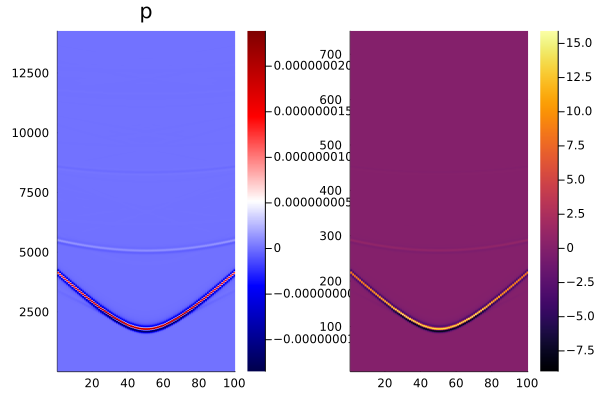

In [12]:
gr()
# pa.c.pml[:x][:a][end-16:end]
data = pa[:data][:p]
p1=heatmap(data, title="p", c=:seismic)
#plot(p1, size=(400,400), layout=(1,3))
data_resampled=resample(data,inv(subsample_factor); dims=1)
d=view(data_resampled,:)
rescale!(d)
p2=heatmap(data_resampled)
plot(p1,p2)
#println("resampled data size: ", size(data_resampled))

In [ ]:
#Generate Velocity Models
#------------------------------------------------------------------------------------------------------------------------
#Set flags
generate_models = true
plot_models = true
view_model = true
#------------------------------------------------------------------------------------------------------------------------
#Set parameters
subsample_factor = 19

num_subsurface_models = 1000 #full scope: 1000
num_water_perturb = 10       #full scope: 10
simulation_number = 124      #ori number: 124

variable_seafloor = false
expand_watervels = true

test1_waterpert = Float32.([-6, -5, -4, -3, -2, 2, 3, 4, 5, 6])
test2_waterpert = Float32.([-6, -5.5, -5, -4.5, -4, 4, 4.5, 5, 5.5, 6])
#test3_waterpert = Float32.([-1, -15, -20, 10, 15, 25, 35, 40, 45, 50])
#------------------------------------------------------------------------------------------------------------------------
simulation_generator = MersenneTwister(simulation_number) #directly controls the seafloor level
#indirectly controls water perturbation amount, subsurface velocities, reflector depths in the subsurface. 

water_number = rand(simulation_generator, 1:10, 1)[1]
water_generator = MersenneTwister(water_number)
vels_number = rand(simulation_generator, 11:21, 1)[1]
vels_generator = MersenneTwister(vels_number)
reflector_number = rand(simulation_generator, 22:32, 1)[1]
reflector_generator = MersenneTwister(reflector_number)

if variable_seafloor
    all_seafloor_levels = Float32.(rand(simulation_generator, 1200:2400, num_subsurface_models)) #variable seafloor
else
    all_seafloor_levels = Float32.(fill(2000, num_subsurface_models)) #constant seafloor - pick 2000m following Kiyashchenko Brazil deepwater paper - previous constant seafloor had 1800m as seafloor level. 
end
all_reflector_depths = Float32.(rand(reflector_generator, 3300:4900, num_subsurface_models))
if expand_watervels
    #expand water velocity perturbation from -25% to 50%
    all_water_perturbs = Float32.(rand(water_generator, (-6000:6000)/1000, (num_subsurface_models, num_water_perturb)))
    #adding controlled water perturbations for samples 901-904 on test data
    all_water_perturbs[901,:] = test2_waterpert
    all_water_perturbs[902,:] = test2_waterpert
    all_water_perturbs[903,:] = test2_waterpert
    all_water_perturbs[904,:] = test2_waterpert
    all_water_perturbs[905,:] = test1_waterpert
    all_water_perturbs[906,:] = test1_waterpert
    all_water_perturbs[907,:] = test1_waterpert
    all_water_perturbs[908,:] = test1_waterpert
else
    all_water_perturbs = Float32.(rand(water_generator, (-2000:2000)/1000, (num_subsurface_models, num_water_perturb)))
end
lower_subsurface_vels = Float32.(rand(vels_generator, 1800:(5700/2), num_subsurface_models))
higher_subsurface_vels = Float32.(rand(vels_generator, 5700/2+1:5700, num_subsurface_models))

if generate_models
    for i in 1:num_subsurface_models
        #generate 1 reference model and save data
        #Set parameters of model - seafloor, subsurface velocities, and reflector depth. 
        water_depth_val = all_seafloor_levels[i]
        reflector_depth_val = all_reflector_depths[i] 
        velocities_val = [lower_subsurface_vels[i], higher_subsurface_vels[i]]   
        model_string = lpad(i,4,"0")
        #Create new medium and acquisition geometry
        n_medium = new_medium(medium; water_depth=water_depth_val, reflector_depth=reflector_depth_val, velocities = velocities_val, water_perturbation=0)
        ageom = get_ageom(;water_depth=water_depth_val)
        GeoPhyInv.update!(pa, ageom)
        GeoPhyInv.update!(pa, n_medium)    
        #Perform forward model   
        update!(pa)
        #Collect Data
        data = pa[:data][:p]
        data_resampled=resample(data,inv(subsample_factor); dims=1)
        d=view(data_resampled,:)
        rescale!(d)
        #Save Data

        fname = "Constant Seafloor 8.8s 6.6vel/seismic_" * model_string * ".00.hf"
        print("save h5")
        datafile = h5open(fname, "w")
        datafile["data"] = data_resampled
        datafile["seafloor_depth"] = water_depth_val
        datafile["reflector_depth"] = reflector_depth_val
        datafile["subsurface velocities"] = velocities_val
        datafile["water_perturbation"] = Float32(0)


        for j in 1:size(all_water_perturbs)[2]
            #Create new medium with updated water velocities, maintain same acquisition geometry as before
            water_perturb_val = all_water_perturbs[i,j]
            water_string = lpad(j,2,"0")
            n_medium = new_medium(medium; water_depth=water_depth_val, reflector_depth=reflector_depth_val, velocities = velocities_val, water_perturbation=water_perturb_val)
            GeoPhyInv.update!(pa, n_medium)
            #Perform forward model
            update!(pa)
            #Collect Data
            data = pa[:data][:p]
            data_resampled=resample(data,inv(subsample_factor); dims=1)        
            d=view(data_resampled,:)
            rescale!(d)
            #Save Data

            fname = "Constant Seafloor 8.8s 6.6vel/seismic_" * model_string * "." * water_string * ".hf"
            print("save h5")
            datafile = h5open(fname, "w")
            datafile["data"] = data_resampled
            datafile["seafloor_depth"] = water_depth_val
            datafile["reflector_depth"] = reflector_depth_val
            datafile["subsurface velocities"] = velocities_val
            datafile["water_perturbation"] = water_perturb_val


        end
    end
end

if plot_models
    num_subsurface_models_to_plot = 3
    num_water_perturbs_to_plot = 10
    plot_medium = true
    plot_seismic = true
#     subsurface_models = Any[]
#     seismic_plots_reference = Any[]
#     seismic_plots_perturbed = Any[]
    
    for i in 1:num_subsurface_models_to_plot
        #generate 1 reference model and save data
        #Set parameters of model - seafloor, subsurface velocities, and reflector depth. 
        water_depth_val = all_seafloor_levels[i]
        reflector_depth_val = all_reflector_depths[i] 
        velocities_val = [lower_subsurface_vels[i], higher_subsurface_vels[i]]   
        model_string = lpad(i,4,"0")
        #Create new medium and acquisition geometry
        n_medium = new_medium(medium; water_depth=water_depth_val, reflector_depth=reflector_depth_val, velocities = velocities_val, water_perturbation=0)
        ageom = get_ageom(;water_depth=water_depth_val)
        GeoPhyInv.update!(pa, ageom)
        GeoPhyInv.update!(pa, n_medium)    
        #Perform forward model   
        update!(pa)
        #Collect Data
        data = pa[:data][:p]
        data_resampled=resample(data,inv(subsample_factor); dims=1)
        d=view(data_resampled,:)
        rescale!(d)
        #plot medium
        if plot_medium
            medium_plot = heatmap(n_medium, size = (600,450), fmt = :png, ylabel="Z (m)", xlabel="X (m)", title = "Domain " * L"$V_p$", clim=(1400,6000), c=:thermal, colorbar_title=" \n" * L"$V_p$" * "(m/s)", right_margin = 4Plots.mm)
            plot!(ageom, Recs())
            plot!(ageom, SSrcs())
            display(medium_plot)
            savefig(medium_plot,"Constant Seafloor 8.8s 6.6vel/Subsurface_medium_"* model_string * ".00.png")
        end
        #plot seismic data
        if plot_seismic
            gr()
            seismic_data=heatmap(data_resampled, clim=(-10,10), c=:seismic, size=(600,500), fmt = :png, xticks= (collect(1:20:101), collect(0:20:100)), xlabel= "Receiver number", yticks= (collect(1:51:751), collect(0:601:8846)), ylabel="Time (ms)", yflip= true)
            display(seismic_data)
            savefig(seismic_data,"Constant Seafloor 8.8s 6.6vel/Shot_gather_"* model_string * ".00.png")
        end

        for j in 1:num_water_perturbs_to_plot
            #Create new medium with updated water velocities, maintain same acquisition geometry as before
            water_perturb_val = all_water_perturbs[i,j]
            water_string = lpad(j,2,"0")
            n_medium = new_medium(medium; water_depth=water_depth_val, reflector_depth=reflector_depth_val, velocities = velocities_val, water_perturbation=water_perturb_val)
            GeoPhyInv.update!(pa, n_medium)
            #Perform forward model
            update!(pa)
            #Collect Data
            data = pa[:data][:p]
            data_resampled=resample(data,inv(subsample_factor); dims=1)        
            d=view(data_resampled,:)
            rescale!(d)
            #don't need to plot medium because it looks exactly the same as the reference subsurface model
            #plot seismic data
            if plot_seismic
                gr()
                seismic_data=heatmap(data_resampled, clim=(-10,10), c=:seismic, size=(600,500), fmt = :png, xticks= (collect(1:20:101), collect(0:20:100)), xlabel= "Receiver number", yticks= (collect(1:51:751), collect(0:601:8846)), ylabel="Time (ms)", yflip= true)
                display(seismic_data)
                savefig(seismic_data,"Constant Seafloor 8.8s 6.6vel/Shot_gather_"* model_string * "." * water_string * ".png")
                println("water perturbed")
            end
        end
    end

end


save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5save h5

In [22]:
if view_model
    nmodel = 901
    water_depth_val = all_seafloor_levels[nmodel]
    reflector_depth_val = all_reflector_depths[nmodel] 
    velocities_val = [lower_subsurface_vels[nmodel], higher_subsurface_vels[nmodel]]   
    #Create new medium and acquisition geometry
    n_medium = new_medium(medium; water_depth=water_depth_val, reflector_depth=reflector_depth_val, velocities = velocities_val, water_perturbation=0)
    ageom = get_ageom(;water_depth=water_depth_val)
    GeoPhyInv.update!(pa, ageom)
    GeoPhyInv.update!(pa, n_medium)    
    #Perform forward model   
    update!(pa)
    data = pa[:data][:p]
    data_resampled=resample(data,inv(subsample_factor); dims=1)        
    d=view(data_resampled,:)
    rescale!(d)
    p1=heatmap(data_resampled, size=(600,500), c=:seismic, clim=(-10,10), yflip=true, xticks= (collect(1:20:101), collect(0:20:100)), 
            xlabel= "Receiver number", yticks= (collect(1:100:751), collect(LinRange(0, 8.8456577, 8))), ylabel="Time (s)")
    plot!(title = "Model 901")
    savefig(p1,"Model902.png")
end


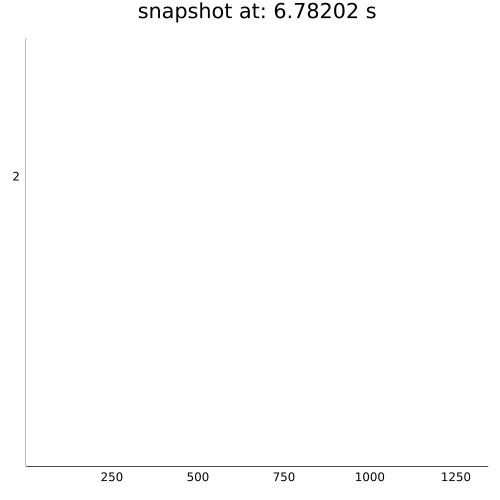

In [15]:
snap_num= 78  #74
gather_snap = pa[:snaps, 1][snap_num]
clip_perc = 50
pmax = maximum([maximum(pa[:snaps][it]) for it = 1:length(tsnaps)])
pmax -= pmax * 0.01 * clip_perc
heatmap(gather_snap, size = (500,500),
                         yticks = (401, "2000m"),
                         xlims = (1, size(gather_snap, 2)),
                         ylims = (1, size(gather_snap, 1)),
                         yflip = true,
                         seriescolor = cgrad(:seismic),
                         clims = (-pmax, pmax),
                         legend = false,
    title = string("snapshot at: ", round(tsnaps[snap_num], digits = 5), " s"))

In [ ]:
plot_snapshots("Model 901 simulation")

In [17]:
# gr()
# #p1==heatmap(data_resampled, clim=(-10,10), c=:seismic,)
# p2=heatmap(data_resampled, clim=(-10,10), c=:seismic, size=(600,500), xticks= (collect(1:20:101), collect(0:20:100)), xlabel= "Receiver number", yticks= (collect(1:1500:14262), collect(LinRange(0, 8.8456577, 10))), ylabel="Time (ms)", yflip= true)
# plot(p2)

In [18]:
minimum(minimum(data_resampled, dims=2), dims=1)

LoadError: SYSTEM: show(lasterr) caused an error

In [19]:
pa[:snaps, 1][1]

InterruptException: InterruptException:

In [20]:
collect(LinRange(0, 8.8456577, 10))

10-element Vector{Float64}:
 0.0
 0.9828508555555555
 1.965701711111111
 2.9485525666666668
 3.931403422222222
 4.914254277777778
 5.8971051333333335
 6.879955988888889
 7.862806844444444
 8.8456577

In [21]:
2000/5+1

401.0